# Recent Signal Lab (Momentum TV Match)

This notebook automatically finds symbols with a **`MomLE` buy signal in the last 5 trading bars** and plots all of them in one run.

- Source signals: `out/momentum_tv_match_daily/*.csv`
- Optional shortlist cache: `out/reports/recent_momentum_buys_5d.csv`
- Plot window: last 3 calendar years


Repo root: /home/unionhills/Projects/GitHub/trading-signals
Momentum dir: out/momentum_tv_match_daily
Recent-window bars: 5
Symbols with recent MomLE buy signal: 6
Symbols: FSLY, GE, GRMN, META, NVDA, SWKS


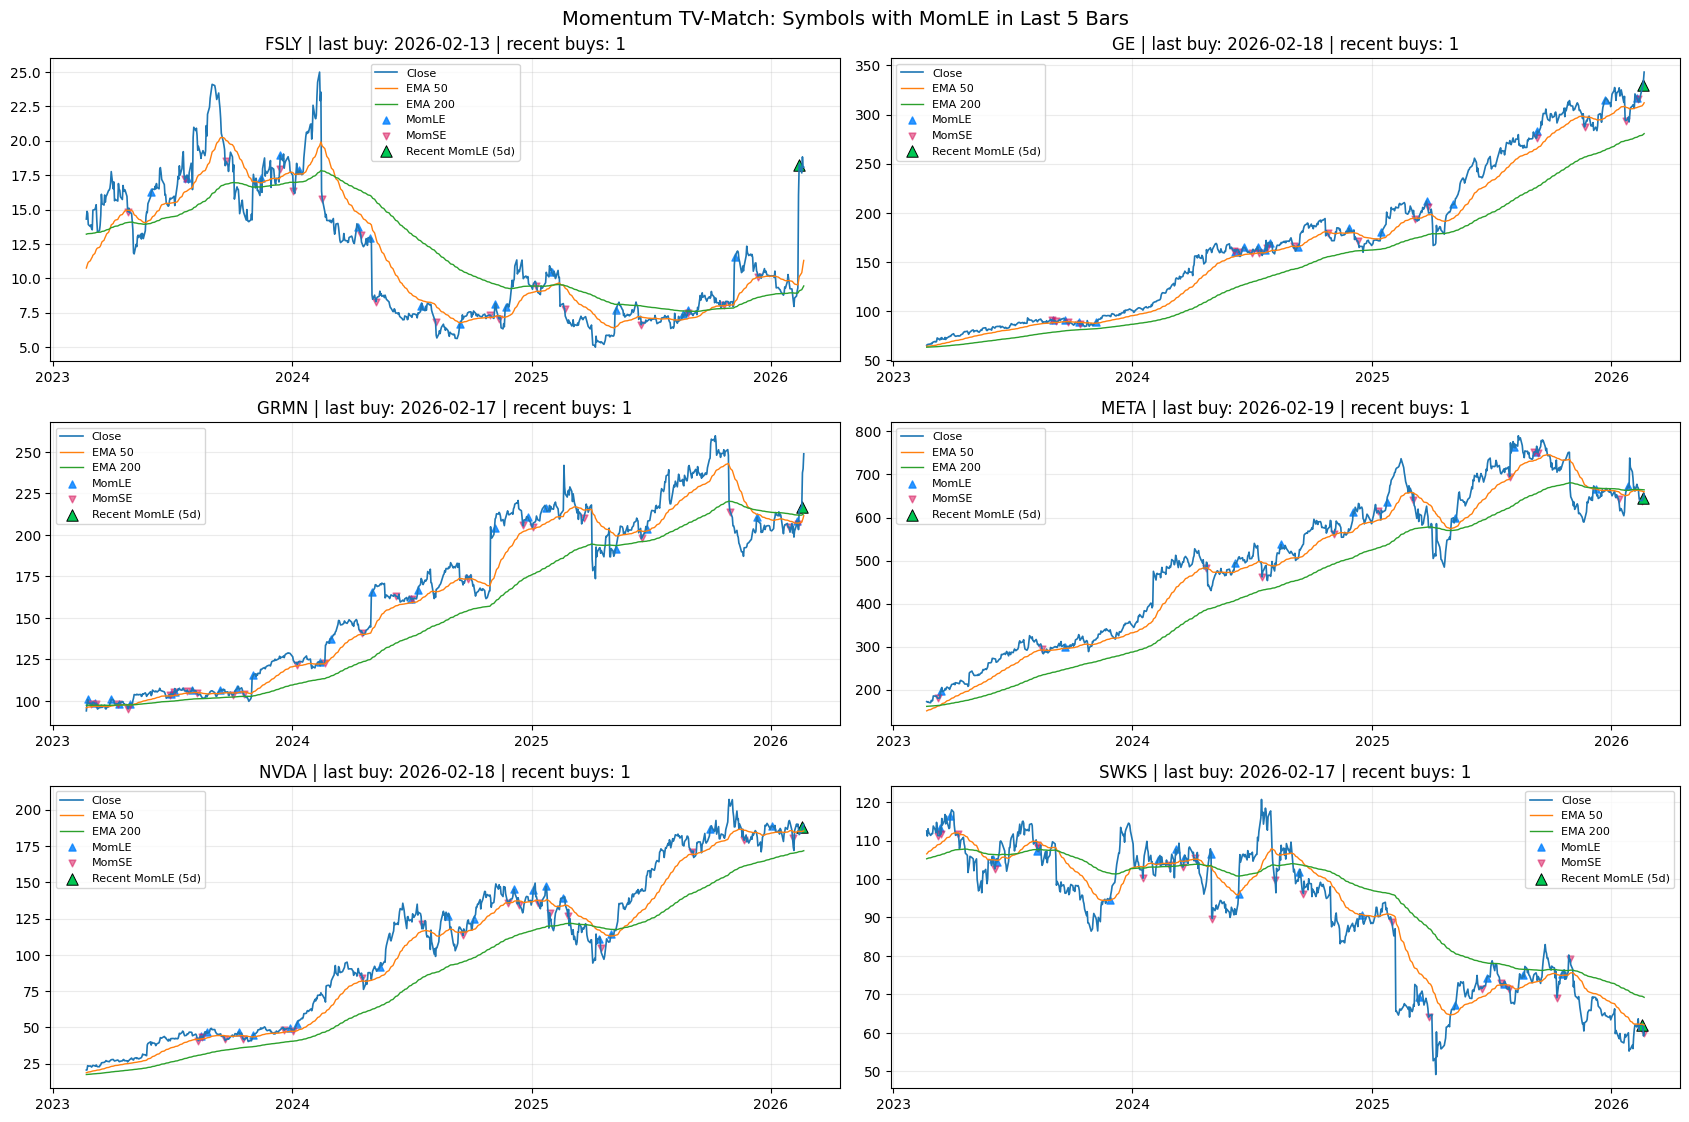

In [1]:
from pathlib import Path
import csv
import math
from datetime import date, timedelta

import matplotlib.dates as mdates
import matplotlib.pyplot as plt

RECENT_WINDOW_BARS = 5
YEARS_TO_PLOT = 3
MOMENTUM_DIR = Path('out/momentum_tv_match_daily')
SHORTLIST_CSV = Path('out/reports/recent_momentum_buys_5d.csv')


def resolve_repo_root() -> Path:
    candidates = [Path.cwd(), Path.cwd().parent]
    for candidate in candidates:
        if (candidate / 'watchlist.txt').exists() and (candidate / 'out').exists():
            return candidate
    return Path.cwd()


ROOT = resolve_repo_root()
MOMENTUM_PATH = ROOT / MOMENTUM_DIR
SHORTLIST_PATH = ROOT / SHORTLIST_CSV


def parse_float(value: str | None) -> float | None:
    raw = (value or '').strip()
    if not raw:
        return None
    return float(raw)


def read_rows(path: Path) -> list[dict[str, str]]:
    with path.open('r', encoding='utf-8', newline='') as handle:
        return list(csv.DictReader(handle))


def compute_ema(values: list[float], period: int) -> list[float | None]:
    out: list[float | None] = [None] * len(values)
    if period <= 0 or len(values) < period:
        return out
    alpha = 2.0 / (period + 1.0)
    seed = sum(values[:period]) / period
    out[period - 1] = seed
    prev = seed
    for idx in range(period, len(values)):
        current = (values[idx] - prev) * alpha + prev
        out[idx] = current
        prev = current
    return out


def scan_recent_buy_signals() -> list[dict[str, str]]:
    results: list[dict[str, str]] = []
    for csv_path in sorted(MOMENTUM_PATH.glob('*.csv')):
        rows = read_rows(csv_path)
        if len(rows) < RECENT_WINDOW_BARS:
            continue
        recent = rows[-RECENT_WINDOW_BARS:]
        buys = [row for row in recent if (row.get('Event') or '').strip() == 'MomLE']
        if not buys:
            continue
        last_buy = buys[-1]
        results.append(
            {
                'Symbol': csv_path.stem,
                'SignalDate': last_buy.get('Date', ''),
                'RecentBuySignals5d': str(len(buys)),
                'Close': last_buy.get('Close', ''),
                'MOM0': last_buy.get('MOM0', ''),
                'MOM1': last_buy.get('MOM1', ''),
                'Position': last_buy.get('Position', ''),
            }
        )
    return results


def load_recent_symbols() -> list[dict[str, str]]:
    if SHORTLIST_PATH.exists():
        rows = read_rows(SHORTLIST_PATH)
        if rows:
            return rows
    return scan_recent_buy_signals()


recent_symbols = load_recent_symbols()

print(f'Repo root: {ROOT}')
print(f'Momentum dir: {MOMENTUM_PATH.relative_to(ROOT)}')
print(f'Recent-window bars: {RECENT_WINDOW_BARS}')
print(f'Symbols with recent MomLE buy signal: {len(recent_symbols)}')
print('Symbols:', ', '.join(row['Symbol'] for row in recent_symbols) if recent_symbols else '(none)')

if not recent_symbols:
    raise RuntimeError('No symbols with MomLE in the last 5 bars.')

n = len(recent_symbols)
cols = 2 if n > 1 else 1
rows_count = math.ceil(n / cols)
fig, axes = plt.subplots(rows_count, cols, figsize=(8.5 * cols, 3.8 * rows_count), squeeze=False)
axes_flat = [ax for row_axes in axes for ax in row_axes]

for idx, info in enumerate(recent_symbols):
    ax = axes_flat[idx]
    symbol = info['Symbol']
    csv_path = MOMENTUM_PATH / f'{symbol}.csv'
    rows = read_rows(csv_path)

    dates: list[date] = []
    closes: list[float] = []
    events: list[str] = []
    for row in rows:
        close = parse_float(row.get('Close'))
        if close is None:
            continue
        dates.append(date.fromisoformat(row['Date']))
        closes.append(close)
        events.append((row.get('Event') or '').strip())

    if not dates:
        ax.set_title(f'{symbol} (no data)')
        ax.axis('off')
        continue

    ema50 = compute_ema(closes, 50)
    ema200 = compute_ema(closes, 200)

    start_date = dates[-1] - timedelta(days=365 * YEARS_TO_PLOT)
    start_idx = next((i for i, d in enumerate(dates) if d >= start_date), 0)

    plot_dates = dates[start_idx:]
    plot_closes = closes[start_idx:]
    plot_ema50 = ema50[start_idx:]
    plot_ema200 = ema200[start_idx:]
    plot_events = events[start_idx:]

    momle_x = [d for d, e in zip(plot_dates, plot_events) if e == 'MomLE']
    momle_y = [c for c, e in zip(plot_closes, plot_events) if e == 'MomLE']
    momse_x = [d for d, e in zip(plot_dates, plot_events) if e == 'MomSE']
    momse_y = [c for c, e in zip(plot_closes, plot_events) if e == 'MomSE']

    recent_slice_start = max(0, len(rows) - RECENT_WINDOW_BARS)
    recent_rows = rows[recent_slice_start:]
    recent_buy_dates = {date.fromisoformat(r['Date']) for r in recent_rows if (r.get('Event') or '').strip() == 'MomLE'}
    recent_momle_x = [d for d in momle_x if d in recent_buy_dates]
    recent_momle_y = [y for d, y in zip(momle_x, momle_y) if d in recent_buy_dates]

    ax.plot(plot_dates, plot_closes, label='Close', color='#1f77b4', linewidth=1.2)
    ax.plot(plot_dates, [float('nan') if v is None else v for v in plot_ema50], label='EMA 50', color='#ff7f0e', linewidth=1.0)
    ax.plot(plot_dates, [float('nan') if v is None else v for v in plot_ema200], label='EMA 200', color='#2ca02c', linewidth=1.0)

    if momle_x:
        ax.scatter(momle_x, momle_y, marker='^', s=26, color='#0a84ff', alpha=0.85, label='MomLE')
    if momse_x:
        ax.scatter(momse_x, momse_y, marker='v', s=24, color='#d81b60', alpha=0.55, label='MomSE')
    if recent_momle_x:
        ax.scatter(recent_momle_x, recent_momle_y, marker='^', s=68, color='#00c853', edgecolors='black', linewidths=0.7, label='Recent MomLE (5d)')

    buy_count = info.get('RecentBuySignals5d', '')
    signal_date = info.get('SignalDate', '')
    ax.set_title(f"{symbol} | last buy: {signal_date} | recent buys: {buy_count}")
    ax.grid(alpha=0.25)
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.legend(loc='best', fontsize=8)

for idx in range(len(recent_symbols), len(axes_flat)):
    axes_flat[idx].axis('off')

fig.suptitle('Momentum TV-Match: Symbols with MomLE in Last 5 Bars', fontsize=14)
fig.tight_layout()
plt.show()
